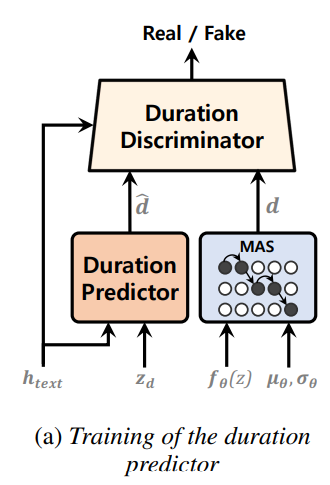

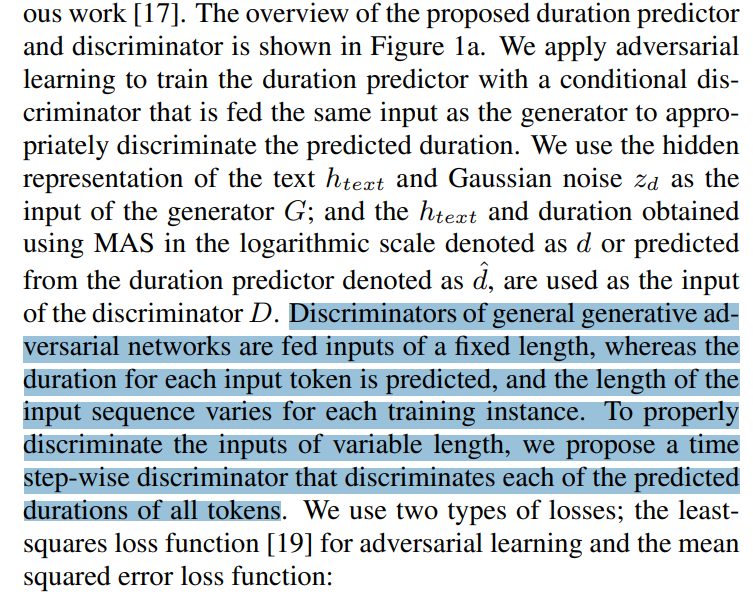


"We used several convolution layers on h_text, projected the duration to a specific dimension, then concatenated them and fed it to several convolution layers again to get output" - Author's feedback.

In [21]:
import os
os.chdir(r'../../vits2_pytorch')

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import modules

In [98]:
class DurationDiscriminator(nn.Module):
  def __init__(self, in_channels, filter_channels, kernel_size, p_dropout, gin_channels=0):
    super().__init__()

    self.in_channels = in_channels
    self.filter_channels = filter_channels
    self.kernel_size = kernel_size
    self.p_dropout = p_dropout
    self.gin_channels = gin_channels

    self.drop = nn.Dropout(p_dropout)
    self.conv_1 = nn.Conv1d(in_channels, filter_channels, kernel_size, padding=kernel_size//2)
    self.norm_1 = modules.LayerNorm(filter_channels)
    self.conv_2 = nn.Conv1d(filter_channels, filter_channels, kernel_size, padding=kernel_size//2)
    self.norm_2 = modules.LayerNorm(filter_channels)
    self.dur_proj = nn.Conv1d(1, filter_channels, 1)

    self.pre_out_conv_1 = nn.Conv1d(2*filter_channels, filter_channels, kernel_size, padding=kernel_size//2)
    self.pre_out_norm_1 = modules.LayerNorm(filter_channels)
    self.pre_out_conv_2 = nn.Conv1d(filter_channels, filter_channels, kernel_size, padding=kernel_size//2)
    self.pre_out_norm_2 = modules.LayerNorm(filter_channels)

    if gin_channels != 0:
      self.cond = nn.Conv1d(gin_channels, in_channels, 1)

    self.output_layer = nn.Sequential(
        nn.Linear(filter_channels, 1), 
        nn.Sigmoid() 
    )

  def forward_probability(self, x, x_mask, dur, g=None):
    dur = self.dur_proj(dur)
    x = torch.cat([x, dur], dim=1)
    x = self.pre_out_conv_1(x * x_mask)
    x = torch.relu(x)
    x = self.pre_out_norm_1(x)
    x = self.drop(x)
    x = self.pre_out_conv_2(x * x_mask)
    x = torch.relu(x)
    x = self.pre_out_norm_2(x)
    x = self.drop(x)
    x = x * x_mask
    x = x.transpose(1, 2)
    output_prob = self.output_layer(x)
    return output_prob

  def forward(self, x, x_mask, dur_r, dur_hat, g=None):
    x = torch.detach(x)
    if g is not None:
      g = torch.detach(g)
      x = x + self.cond(g)
    x = self.conv_1(x * x_mask)
    x = torch.relu(x)
    x = self.norm_1(x)
    x = self.drop(x)
    x = self.conv_2(x * x_mask)
    x = torch.relu(x)
    x = self.norm_2(x)
    x = self.drop(x)
    
    output_probs = []
    for dur in [dur_r, dur_hat]:
      output_prob = self.forward_probability(x, x_mask, dur, g)
      output_probs.append(output_prob)
    
    return output_probs

In [99]:
# in_channels, filter_channels, kernel_size, p_dropout, gin_channels=0
discriminator = DurationDiscriminator(
    in_channels=192,
    filter_channels=192,
    kernel_size=3,
    p_dropout=0.1,
    gin_channels=0,
)

In [100]:
# x, x_mask, dur_r, dur_hat, g=None
x = torch.rand(1, 192, 10)
x_mask = torch.ones(1, 1, 10)
dur_r = torch.rand(1, 1, 10)
dur_hat = torch.rand(1, 1, 10)
g = None

output_prob_r, output_prob_hat = discriminator(x, x_mask, dur_r, dur_hat, g)

In [104]:
output_prob_r, output_prob_hat # 10 different probabilities for each 10 timesteps

(tensor([[[0.5418],
          [0.5600],
          [0.3504],
          [0.3118],
          [0.4333],
          [0.4482],
          [0.4961],
          [0.2816],
          [0.4769],
          [0.3629]]], grad_fn=<SigmoidBackward0>),
 tensor([[[0.5607],
          [0.6866],
          [0.4617],
          [0.2704],
          [0.3406],
          [0.4315],
          [0.5214],
          [0.3601],
          [0.4282],
          [0.3380]]], grad_fn=<SigmoidBackward0>))

In [103]:
adv_loss = ((output_prob_r - 1)**2).mean() + (output_prob_hat**2).mean()
adv_loss

tensor(0.5448, grad_fn=<AddBackward0>)